# Data science assessment - Fraud data

## objective
> to buld a machine learning model that predicts the probability that the first transaction of a new user is fraudulent

## details
- 'Electronica' : e-commerce site that sells wholesale electronics
- want to know a given transaction is fraudulent or not
- data of user's first transaction
- costs
    - fail to detect fraud : Electronica loses money equivalent to the price
    - false alert          : cost my client values 8$

In [2]:
# python built-in libraries
import os
from collections import Counter
from datetime import datetime, timedelta

# python third party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# setting
random_state = 79

## load data

In [3]:
directory = os.getcwd()
directory

'/Users/nm-n2204009/Desktop/notes/novelis'

In [69]:
fraud_data = pd.read_csv(directory + '/dataset/df_final.csv', index_col=0)
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,signup_time_date,purchase_time_date,time_to_purchase,user_id_count,country
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,2015-07-15,2015-09-10,57,2,United States
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,2015-01-24,2015-04-13,79,1,United Kingdom
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,2015-03-11,2015-04-05,25,1,United States
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,2015-01-07,2015-01-09,2,1,Korea Republic of
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,2015-02-08,2015-04-09,60,1,Brazil


## preprocess

In [70]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 0 to 119999
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             120000 non-null  int64  
 1   signup_time         120000 non-null  object 
 2   purchase_time       120000 non-null  object 
 3   purchase_value      120000 non-null  int64  
 4   device_id           120000 non-null  object 
 5   source              120000 non-null  object 
 6   browser             120000 non-null  object 
 7   sex                 120000 non-null  object 
 8   age                 120000 non-null  int64  
 9   ip_address          120000 non-null  float64
 10  class               120000 non-null  int64  
 11  signup_time_date    120000 non-null  object 
 12  purchase_time_date  120000 non-null  object 
 13  time_to_purchase    120000 non-null  int64  
 14  user_id_count       120000 non-null  int64  
 15  country             102582 non-nul

#### make month for signup

In [71]:
fraud_data['signup_time_date'][0]

'2015-07-15'

In [72]:
type(fraud_data['signup_time_date'][0])

str

In [73]:
fraud_data['signup_time_date'][0].split('-')[1]

'07'

In [74]:
fraud_data['purchase_month'] = fraud_data['purchase_time_date'].map(lambda x : x.split('-')[1])
fraud_data['purchase_month']

0         09
1         04
2         04
3         01
4         04
          ..
119995    04
119996    08
119997    09
119998    06
119999    09
Name: purchase_month, Length: 120000, dtype: object

In [75]:
fraud_data['signup_month'] = fraud_data['signup_time_date'].map(lambda x : x.split('-')[1])
fraud_data['signup_month']

0         07
1         01
2         03
3         01
4         02
          ..
119995    02
119996    08
119997    07
119998    04
119999    07
Name: signup_month, Length: 120000, dtype: object

### make dummy data

In [76]:
gender_dummy         = pd.get_dummies(fraud_data.sex, drop_first = True)
signup_month_dummy   = pd.get_dummies(fraud_data.signup_month, drop_first = True, prefix = 'signup')
purchase_month_dummy = pd.get_dummies(fraud_data.purchase_month, drop_first = True, prefix = 'purchase')
source_dummy         = pd.get_dummies(fraud_data.source, drop_first = True)
browser_dummy        = pd.get_dummies(fraud_data.browser, drop_first = True)

fraud_data = fraud_data.drop(['sex','signup_month', 'purchase_month', 'source','browser'], axis=1)

final = pd.concat([fraud_data, gender_dummy, signup_month_dummy, purchase_month_dummy, source_dummy, browser_dummy], axis=1)
final.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,signup_time_date,purchase_time_date,...,purchase_09,purchase_10,purchase_11,purchase_12,Direct,SEO,FireFox,IE,Opera,Safari
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,49,2.818400e+09,0,2015-07-15,2015-09-10,...,1,0,0,0,1,0,0,0,0,0
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,21,3.251268e+09,0,2015-01-24,2015-04-13,...,0,0,0,0,0,1,0,1,0,0
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,26,2.727760e+09,0,2015-03-11,2015-04-05,...,0,0,0,0,1,0,0,1,0,0
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,34,2.083420e+09,0,2015-01-07,2015-01-09,...,0,0,0,0,0,1,0,0,0,0
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,33,3.207913e+09,0,2015-02-08,2015-04-09,...,0,0,0,0,0,0,1,0,0,0


## selected features
- date related features
    - signup_time_month dummy
    - purchase_time_month dummy
    - time_to_purchase
- user related feature
    - sex dummy
    - age
    - browser dummy
    - source dummy
    - the number of user_id connected to the device id

In [77]:
final.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'age', 'ip_address', 'class', 'signup_time_date',
       'purchase_time_date', 'time_to_purchase', 'user_id_count', 'country',
       'M', 'signup_02', 'signup_03', 'signup_04', 'signup_05', 'signup_06',
       'signup_07', 'signup_08', 'purchase_02', 'purchase_03', 'purchase_04',
       'purchase_05', 'purchase_06', 'purchase_07', 'purchase_08',
       'purchase_09', 'purchase_10', 'purchase_11', 'purchase_12', 'Direct',
       'SEO', 'FireFox', 'IE', 'Opera', 'Safari'],
      dtype='object')

In [78]:
final = final.drop(['signup_time', 'purchase_time', 'device_id', 'ip_address', 'signup_time_date', 'purchase_time_date', 'country'], axis = 1)
final.columns

Index(['user_id', 'purchase_value', 'age', 'class', 'time_to_purchase',
       'user_id_count', 'M', 'signup_02', 'signup_03', 'signup_04',
       'signup_05', 'signup_06', 'signup_07', 'signup_08', 'purchase_02',
       'purchase_03', 'purchase_04', 'purchase_05', 'purchase_06',
       'purchase_07', 'purchase_08', 'purchase_09', 'purchase_10',
       'purchase_11', 'purchase_12', 'Direct', 'SEO', 'FireFox', 'IE', 'Opera',
       'Safari'],
      dtype='object')

## deal with highly imbalanced data

- undesr sampling
    - can be balanced but lot of informations are lost
- over sampling
    - can be balanced but incorrect data could be input for learning
- In this questions...
    - split class=0 data into 5 peaces to make 5 diffenrect dataset with same class=1 data

In [79]:
final_0 = final.loc[final['class'] == 0,]
final_1 = final.loc[final['class'] == 1,]

In [80]:
final_0 = final_0.sample(frac=1).reset_index(drop=True)
final_0

,user_id,purchase_value,age,class,time_to_purchase,user_id_count,M,signup_02,signup_03,signup_04,...,purchase_09,purchase_10,purchase_11,purchase_12,Direct,SEO,FireFox,IE,Opera,Safari
0,296415,40,37,0,65,1,1,1,0,0,...,0,0,0,0,0,1,1,0,0,0
1,20148,24,29,0,70,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,302402,83,20,0,50,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,12759,30,26,0,33,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,209772,35,29,0,48,1,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108730,61042,34,59,0,34,1,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0
108731,578,21,25,0,36,1,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
108732,113438,25,28,0,9,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108733,237955,37,26,0,88,1,1,1,0,0,...,0,0,0,0,0,1,0,1,0,0


In [81]:
flag = len(final_0)//5
flag

21747

In [82]:
final_0_1 = final_0.iloc[:flag,:]
final_0_2 = final_0.iloc[flag   : flag*2,:]
final_0_3 = final_0.iloc[flag*2 : flag*3,:]
final_0_4 = final_0.iloc[flag*3 : flag*4,:]
final_0_5 = final_0.iloc[flag*4 : :]

In [83]:
final__1 = pd.concat([final_0_1, final_1], axis=0).sample(frac=1).reset_index(drop=True)
final__2 = pd.concat([final_0_2, final_1], axis=0).sample(frac=1).reset_index(drop=True)
final__3 = pd.concat([final_0_3, final_1], axis=0).sample(frac=1).reset_index(drop=True)
final__4 = pd.concat([final_0_4, final_1], axis=0).sample(frac=1).reset_index(drop=True)
final__5 = pd.concat([final_0_5, final_1], axis=0).sample(frac=1).reset_index(drop=True)

## test

In [84]:
X = final__1.drop(['user_id','class'], axis = 1)
y = final__1['class']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [86]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [91]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': range(100, 500, 100),
    'max_depth': range(5, 15, 5),
    'max_features': np.arange(0.1, 0.9, 0.1)
}
cv = RandomizedSearchCV(
    rf,
    param_grid,
    n_iter = 25,
    cv = 3,
    scoring='f1',
    random_state = random_state,
    verbose = 5
)
cv.fit(X_train_scaled, y_train)

rf_best = cv.best_estimator_

print('Random forest CV score')
print(cross_val_score(rf_best, X_train_scaled, y_train, scoring='f1', cv=5))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END max_depth=5, max_features=0.7000000000000001, n_estimators=200;, score=0.765 total time=   1.9s
[CV 2/3] END max_depth=5, max_features=0.7000000000000001, n_estimators=200;, score=0.761 total time=   1.8s
[CV 3/3] END max_depth=5, max_features=0.7000000000000001, n_estimators=200;, score=0.766 total time=   1.8s
[CV 1/3] END max_depth=10, max_features=0.6, n_estimators=200;, score=0.762 total time=   2.6s
[CV 2/3] END max_depth=10, max_features=0.6, n_estimators=200;, score=0.756 total time=   2.6s
[CV 3/3] END max_depth=10, max_features=0.6, n_estimators=200;, score=0.763 total time=   2.6s
[CV 1/3] END max_depth=10, max_features=0.1, n_estimators=200;, score=0.702 total time=   0.9s
[CV 2/3] END max_depth=10, max_features=0.1, n_estimators=200;, score=0.703 total time=   0.9s
[CV 3/3] END max_depth=10, max_features=0.1, n_estimators=200;, score=0.724 total time=   0.9s
[CV 1/3] END max_depth=5, max_features=0.3

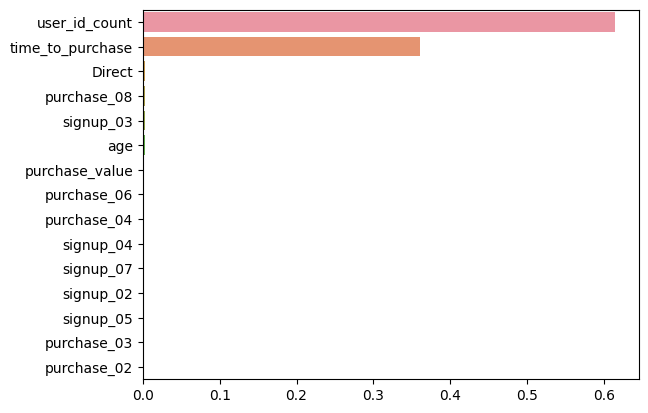

In [92]:
imp = pd.Series(rf_best.feature_importances_,
                index = X_train.columns)
top15 = imp.sort_values(ascending=False)[:15]

sns.barplot(x=top15, y=top15.index)
plt.show()

In [89]:
Counter(final__1['class'])[0]/len(final__1)

0.6587604507451835

In [90]:
gb = GradientBoostingClassifier()

param_grid = {
    'n_estimators': range(100, 500, 100),
    'max_depth': range(5, 15,5),
    'learning_rate': np.arange(0.01, 0.2, 0.02)
}
cv = RandomizedSearchCV(
    gb,
    param_grid,
    n_iter = 25,
    cv = 3,
    scoring='f1',
    random_state = random_state,
    verbose = 5
)
cv.fit(X_train_scaled, y_train)

gb_best = cv.best_estimator_

print('Gradient boosting CV score')
print(cross_val_score(gb_best, X_train_scaled, y_train, scoring='f1', cv=5))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END learning_rate=0.18999999999999997, max_depth=5, n_estimators=400;, score=0.737 total time=   7.5s
[CV 2/3] END learning_rate=0.18999999999999997, max_depth=5, n_estimators=400;, score=0.730 total time=   7.3s
[CV 3/3] END learning_rate=0.18999999999999997, max_depth=5, n_estimators=400;, score=0.740 total time=   7.3s
[CV 1/3] END learning_rate=0.18999999999999997, max_depth=10, n_estimators=300;, score=0.724 total time=  12.0s
[CV 2/3] END learning_rate=0.18999999999999997, max_depth=10, n_estimators=300;, score=0.724 total time=  12.0s
[CV 3/3] END learning_rate=0.18999999999999997, max_depth=10, n_estimators=300;, score=0.737 total time=  12.2s
[CV 1/3] END learning_rate=0.049999999999999996, max_depth=5, n_estimators=300;, score=0.754 total time=   5.5s
[CV 2/3] END learning_rate=0.049999999999999996, max_depth=5, n_estimators=300;, score=0.748 total time=   5.4s
[CV 3/3] END learning_rate=0.04999999999999999

KeyboardInterrupt: 